# Practica 2 - Natural Language processing

## Librerías

In [1]:
import numpy as np

import tensorflow as tf

import pandas as pd
from collections import Counter
import re

from tensorflow import keras


import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams

from keras.callbacks import TensorBoard

import re
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
from tensorflow.keras.preprocessing.sequence import skipgrams

## Funciones

## Descarga y proceso de datos

### Carga de datos

In [2]:
import os
import pandas as pd

# 1. Directorio portable a P2_NaturalLanguageProcessing/data
cwd      = os.getcwd()
data_dir = os.path.join(cwd, 'data')

# 2. Rutas a los CSV
train_path = os.path.join(data_dir, 'train.csv')
test_path  = os.path.join(data_dir, 'test.csv')

# 3. Lista de codificaciones a probar
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

def load_csv(path, enc_list):
    for enc in enc_list:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Cargado '{os.path.basename(path)}' con encoding {enc}")
            return df, enc
        except UnicodeDecodeError:
            print(f"Fallo con encoding {enc}, probando siguiente...")
    raise ValueError(f"No se pudo decodificar {path} con las codificaciones {enc_list}")

# 4. Cargar ambos conjuntos usando la misma codificación
train_df, used_enc = load_csv(train_path, encodings)
test_df, _      = load_csv(test_path, [used_enc])

# 5. Verificación
print(f"Train shape: {train_df.shape}")
print(f"Test  shape: {test_df.shape}")


Fallo con encoding utf-8, probando siguiente...
Cargado 'train.csv' con encoding latin1
Cargado 'test.csv' con encoding latin1
Train shape: (27481, 10)
Test  shape: (4815, 9)


### Exploración y limpieza de datos

In [3]:
# 5. Juntar los DataFrames para facilitar el preprocesado
data_df = pd.concat([train_df, test_df], ignore_index=True)      # concatenación[2]

# 6. Inspeccionar estructura básica
print(data_df.info())
print(data_df.head())

# 7. Contar palabras únicas en la columna 'text' para estimar VOCAB_SIZE
all_text = ' '.join(data_df['text'].astype(str)).lower()
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words)
unique_words = len(word_counts)

print(f"Total de muestras: {data_df.shape[0]}")
print(f"Palabras únicas encontradas: {unique_words}")
print("Top 10 palabras más frecuentes:", word_counts.most_common(10))

# 8. Definir parámetros para TensorFlow/Keras
BUFFER_SIZE = 32768      # chivo mayor al dataset para buen shuffle 2^15
BATCH_SIZE = 128        # potencia de 2 adecuada para GPU
VOCAB_SIZE = 8192      # tamaño del vocabulario[4]

print("BUFFER_SIZE =", BUFFER_SIZE)
print("BATCH_SIZE =", BATCH_SIZE)
print("VOCAB_SIZE =", VOCAB_SIZE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32296 entries, 0 to 32295
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.5+ MB
None
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...  

### Preparación de datos

#### Creación del corpus

In [4]:
# 1. Seleccionar las 4 096 palabras más frecuentes
most_common_words = {w for w, _ in word_counts.most_common(VOCAB_SIZE)}

# 2. Filtrar cada texto para quedarnos solo con tokens en el top 4 096
corpus_filtered = []
for text in data_df['text'].dropna().astype(str):
    tokens = re.findall(r'\b\w+\b', text.lower())
    filtered_tokens = [t for t in tokens if t in most_common_words]
    corpus_filtered.append(" ".join(filtered_tokens))

# 3. Tokenizar el corpus filtrado
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(corpus_filtered)

# 4. Convertir textos a secuencias de índices
sequences = tokenizer.texts_to_sequences(corpus_filtered)

# 5. Diccionarios de mapeo y tamaño final de vocabulario
word2idx = tokenizer.word_index
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = min(len(word2idx) + 1, VOCAB_SIZE)

# 6. Mostrar resultados de prueba
print("Primeros 5 textos filtrados:", corpus_filtered[:5])
print("Primeras 5 secuencias:", sequences[:5])
print("Tamaño de vocabulario efectivo:", vocab_size)


Primeros 5 textos filtrados: ['i d have responded if i were going', 'sooo sad i will miss you here in san diego', 'my boss is me', 'what interview leave me alone', 'sons of why couldn t they put them on the releases we already bought']
Primeras 5 secuencias: [[1, 163, 19, 7648, 71, 1, 151, 49], [421, 117, 1, 63, 94, 7, 91, 10, 1447, 2230], [5, 1410, 9, 16], [51, 1193, 350, 16, 495], [4254, 13, 118, 472, 14, 72, 332, 131, 17, 3, 7649, 50, 210, 569]]
Tamaño de vocabulario efectivo: 8152


#### Generación de los pares de entrenamiento

In [5]:
# Parámetros generales
# vocab_size_eff    = vocab_size    # p.ej. 8192
negative_samples  = 0.0
seed_value        = 42

# Ventanas para generar pares
window_sizes = [2, 4]

# Contenedor de pares por tamaño de ventana
pairs_by_window = {}

for w in window_sizes:
    pairs = []
    for seq in sequences:
        if len(seq) < 2:
            continue
        # Generar solo pares positivos con skipgrams
        pos_pairs, _ = skipgrams(
            sequence=seq,
            vocabulary_size=vocab_size,
            window_size=w,
            negative_samples=negative_samples,
            shuffle=True,
            seed=seed_value
        )
        pairs.extend(pos_pairs)

    # Convertir a arrays target/context
    if pairs:
        t, c = zip(*pairs)
        targets  = np.array(t, dtype='int32')
        contexts = np.array(c, dtype='int32')
    else:
        targets  = np.zeros((0,), dtype='int32')
        contexts = np.zeros((0,), dtype='int32')

    pairs_by_window[w] = {
        'pairs':   pairs,
        'targets': targets,
        'contexts':contexts
    }
    print(f"Window={w}: {len(pairs)} pares generados")

# Ejemplo de acceso:
# pairs_by_window[2]['targets'], pairs_by_window[2]['contexts']
# pairs_by_window[4]['targets'], pairs_by_window[4]['contexts']



Window=2: 1384586 pares generados
Window=4: 2530442 pares generados


#### Integer-encoding
Un poco de teoría de los dos encoders:

- Integer encoding: X_target y X_context son vectores de enteros donde cada valor es el índice de palabra en el vocabulario. Es lo adecuado cuando se usa una capa Embedding, ya que Keras transforma internamente cada índice en su vector embebido.

- One-hot encoding: cada índice se convierte en un vector binario de longitud vocab_size con un único 1 en la posición correspondiente al índice. Ocupa mucha más memoria y rara vez es necesario si tu primer bloque es Embedding.

In [6]:
import numpy as np

# Suponemos que ya existe:
#  - pairs_by_window: dict con keys 2 y 4, cada uno contiene 'targets' y 'contexts'
#  - vocab_size: tamaño efectivo del vocabulario (p.ej. 8192)

datasets = {}

for w, data in pairs_by_window.items():
    # 1. Extraer targets y contexts
    targets  = data['targets']    # array shape (n_pairs,)
    contexts = data['contexts']   # array shape (n_pairs,)

    # 2. Crear X_train como representación dispersa (enteros)
    X_target  = targets
    X_context = contexts
    X_train   = [X_target, X_context]

    # 3. Etiquetas positivas
    y_train = np.ones((len(targets),), dtype='int32')

    # 4. Almacenar en el nuevo dict
    datasets[w] = {
        'X_train': X_train,
        'y_train': y_train
    }

    # 5. Mostrar shapes de comprobación
    print(f"--- Ventana = {w} ---")
    print("Número de pares:", len(targets))
    print("X_target shape:",  X_target.shape)
    print("X_context shape:", X_context.shape)
    print("y_train shape:",    y_train.shape)
    print()

# Acceso posterior:
# datasets[2]['X_train'], datasets[2]['y_train']
# datasets[4]['X_train'], datasets[4]['y_train']

--- Ventana = 2 ---
Número de pares: 1384586
X_target shape: (1384586,)
X_context shape: (1384586,)
y_train shape: (1384586,)

--- Ventana = 4 ---
Número de pares: 2530442
X_target shape: (2530442,)
X_context shape: (2530442,)
y_train shape: (2530442,)



## Arquitectura y ejecucción

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape
from tensorflow.keras.optimizers import Adam

def build_skipgram_model(vocab_size,
                         embedding_dim,
                         learning_rate=0.025,
                         beta_1=0.9,
                         beta_2=0.999):
    """
    Devuelve un modelo Skip-Gram compilado que:
     - Recibe dos inputs enteros (target y context, cada uno shape=())
     - Usa una capa Embedding compartida de tamaño (vocab_size, embedding_dim)
     - Calcula el dot-product y pasa por sigmoide
     - Usa binary_crossentropy + Adam
    """
    # 1) capas de entrada (índice único por ejemplo)
    target_input  = Input(shape=(), dtype='int32', name='target_input')
    context_input = Input(shape=(), dtype='int32', name='context_input')

    # 2) capa Embedding compartida
    embed = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=1,
                      name='shared_embedding',
                      embeddings_initializer='glorot_uniform',
                      trainable=True)

    # 3) obtenemos los vectores embebidos y aplanamos
    target_vec  = Reshape((embedding_dim,)) (embed(target_input))
    context_vec = Reshape((embedding_dim,)) (embed(context_input))

    # 4) puntuación = dot-product
    dot_prod = Dot(axes=1, normalize=False, name='dot_product')(
        [target_vec, context_vec]
    )

    # 5) salida sigmoide para predecir par positivo/negativo
    output = Reshape((1,))(dot_prod)
    output = tf.keras.activations.sigmoid(output)

    # 6) construir y compilar modelo
    model = Model(inputs=[target_input, context_input], outputs=output, name=f"skipgram_{embedding_dim}")
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2),
        metrics=['accuracy']
    )
    return model

# --------------------------------------------------------------
# Ejemplo de entrenamiento de los 6 modelos (3 dims × 2 ventanas)
# --------------------------------------------------------------
embedding_dims = [45, 312, 752]
window_sizes   = [2, 4]
histories      = {}

for w in window_sizes:
    X_target, X_context = datasets[w]['X_train']
    y_train             = datasets[w]['y_train']

    for ed in embedding_dims:
        print(f"\nEntrenando Skip-Gram: window={w}, embed_dim={ed}")

        # 1) construir
        model = build_skipgram_model(vocab_size=vocab_size,
                                     embedding_dim=ed,
                                     learning_rate=0.025)

        # 2) entrenar
        history = model.fit(
            x=[X_target, X_context],
            y=y_train,
            batch_size=BATCH_SIZE,
            epochs=10,                # ajusta número de épocas
            verbose=1
        )

        # 3) guardar historia y modelo
        histories[(w, ed)] = history

# Ahora `histories[(w,ed)].history['loss']` contiene la curva de pérdida



Entrenando Skip-Gram: window=2, embed_dim=45


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9846 - loss: 0.0270
Epoch 2/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 1.0000 - loss: 3.5527e-07
Epoch 3/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 1.0000 - loss: 4.0059e-08
Epoch 4/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 1.0000 - loss: 2.0814e-08
Epoch 5/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 1.0000 - loss: 1.3802e-08
Epoch 6/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 1.0000 - loss: 1.0585e-08
Epoch 7/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 1.0000 - loss: 8.3784e-09
Epoch 8/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 1.0000 - loss: 7.0530e-09
Epoch 9/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 1.0000 - loss: 5.9764e-09
Epoch 10/10
10818/10818 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 1.0000 - loss: 5.2894e-09

Entrenando Skip-Gram: window=2, embed_dim=312
Epoch 

## Resultados

### Variación de la pérdida

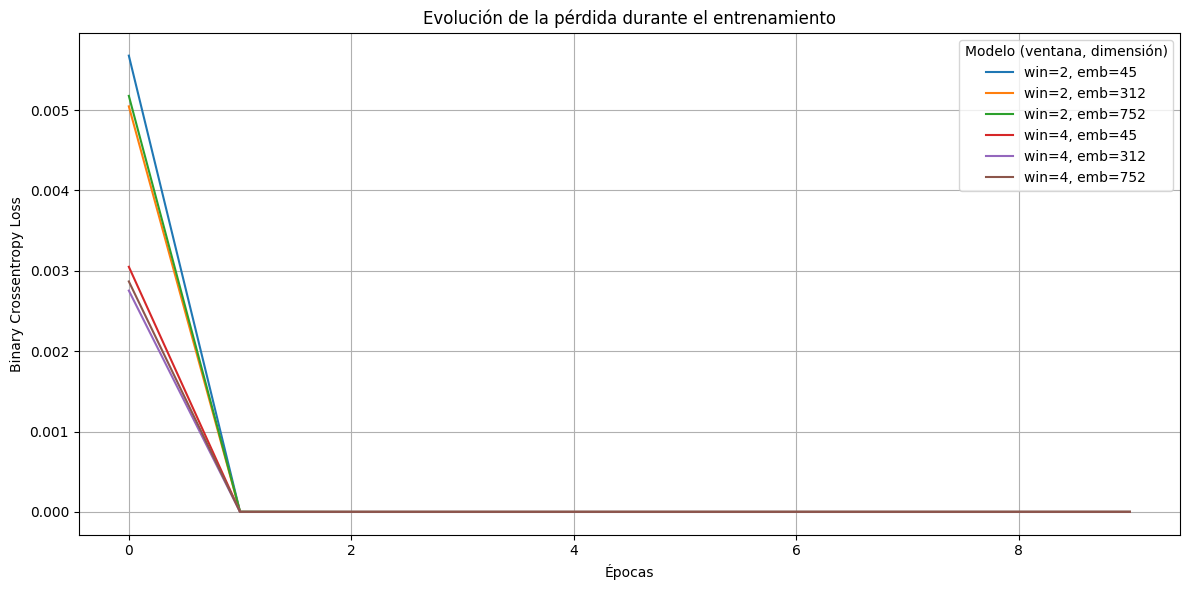

In [8]:
import matplotlib.pyplot as plt

# Dimensiones de embedding y tamaños de ventana usados
embedding_dims = [45, 312, 752]
window_sizes   = [2, 4]

plt.figure(figsize=(12, 6))

for w in window_sizes:
    for ed in embedding_dims:
        key = (w, ed)
        if key not in histories:
            print(f'⚠️ No se encontró historial para ventana={w}, embedding={ed}')
            continue

        loss_values = histories[key].history['loss']
        plt.plot(
            loss_values,
            label=f'win={w}, emb={ed}'
        )

plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Binary Crossentropy Loss')
plt.legend(title='Modelo (ventana, dimensión)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 10 palabras con más significado

 Listado de las 10 palabras más usadas que efectivamente representan nombres o conceptos clave en tu corpus. Este filtro por POS garantiza que excluyas términos funcionales y te concentres en las entidades y sustantivos que aportan verdadero “significado” al análisis.


In [11]:
import spacy
from collections import Counter

# 1) Cargamos el modelo de spaCy para inglés
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# 2) Definimos stopwords (por ejemplo las de spaCy + extras)
stopwords = nlp.Defaults.stop_words.union({
    'http', 'https', 'rt', 'co','nan','com'  # añade tokens no léxicos
})

# 3) Recorremos el word_counts ordenado por frecuencia
meaningful = []
for word, freq in word_counts.most_common():
    if word in stopwords or len(word) < 2:
        continue
    # POS‐tagging de la palabra aislada
    token = nlp(word)[0]
    if token.pos_ in {"NOUN", "PROPN"}:
        meaningful.append((word, freq))
    if len(meaningful) >= 10:
        break

# 4) Resultado
print("Top 10 palabras con significado (spaCy):")
for w, f in meaningful:
    print(f"{w}: {f}")


Top 10 palabras con significado (spaCy):
day: 2349
love: 1304
today: 1273
lol: 1149
time: 1080
don: 993
night: 878
home: 825
thanks: 768
hope: 682


### Operaciones con los embeddings

#### Comparación de las 10 palabras seleccionadas

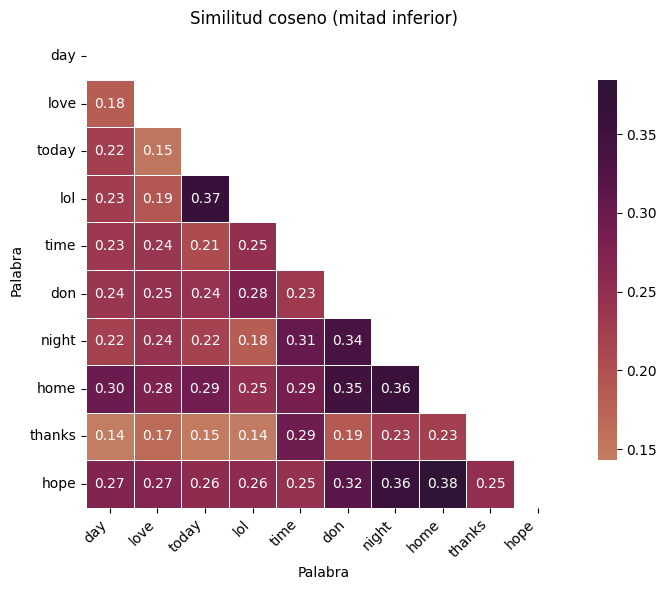

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Suponemos que ya tienes:
#  - model: tu Skip-Gram entrenado (p.ej. build_skipgram_model con window=2, embedding_dim=312)
#  - word2idx: diccionario palabra→índice
#  - meaningful: lista de tuples [(word, freq), ...] con tus 10 palabras

# Extraemos solo las 10 palabras
words_10 = [w for w, _ in meaningful[:10]]

# 1) Obtenemos la matriz de embeddings (vocab_size × embedding_dim)
embedding_layer = model.get_layer('shared_embedding')
embeddings = embedding_layer.get_weights()[0]

# 2) Recopilamos los vectores de las 10 palabras
vectors_10 = []
for w in words_10:
    idx = word2idx.get(w)
    if idx is not None and idx < embeddings.shape[0]:
        vectors_10.append(embeddings[idx])
    else:
        # Si la palabra no existe en el vocabulario, usamos un vector cero
        vectors_10.append(np.zeros(embeddings.shape[1], dtype=float))
vectors_10 = np.vstack(vectors_10)

# 3) Calculamos la similitud coseno
sim_matrix = cosine_similarity(vectors_10)

# 4) Presentamos los resultados en un DataFrame
df_sim = pd.DataFrame(
    sim_matrix,
    index=words_10,
    columns=words_10
)

# 1) Calcula la matriz de similitud coseno
sim_matrix = cosine_similarity(vectors_10)

# 2) Construye el DataFrame
df_sim = pd.DataFrame(sim_matrix, index=words_10, columns=words_10)

# 3) Crea una máscara para la mitad superior
mask = np.triu(np.ones_like(df_sim, dtype=bool))

# 4) Dibuja el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_sim,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="twilight_shifted",
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title("Similitud coseno (mitad inferior)");
plt.xlabel("Palabra");
plt.ylabel("Palabra")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Mirar 3 grupos de palabras similares

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# 1) Definición de los tres grupos y de sus índices
group1 = [4723, 6892, 7183, 7890, 3841]        # aaaah, aaah, aaahhh, aaawww, aah
group2 = [7532, 505, 625, 5254, 2062]          # leon, dog, cat, wolf, horse
group3 = [5817, 1191, 1330, 5817, 140]         # avenue, road, street, avenue, way

all_indices = group1 + group2 + group3

# 2) Construir la lista de palabras usando idx2word (invertido de word2idx)
idx2word = {idx: w for w, idx in word2idx.items()}
words_15 = [idx2word.get(i, f"idx{i}") for i in all_indices]

# 3) Extraer la matriz de embeddings del modelo ya entrenado
emb_layer = model.get_layer('shared_embedding')
emb_matrix = emb_layer.get_weights()[0]        # forma = (vocab_size, embedding_dim)

# 4) Recoger los vectores para las 15 palabras
vectors_15 = []
for idx in all_indices:
    if idx < emb_matrix.shape[0]:
        vectors_15.append(emb_matrix[idx])
    else:
        vectors_15.append(np.zeros(emb_matrix.shape[1]))
vectors_15 = np.vstack(vectors_15)

# 5) Calcular similitud coseno y distancia (1–coseno)
sim_matrix = cosine_similarity(vectors_15)
dist_matrix = 1 - sim_matrix

# 6) DataFrame para visualización
df_sim  = pd.DataFrame(sim_matrix, index=words_15, columns=words_15)
df_dist = pd.DataFrame(dist_matrix, index=words_15, columns=words_15)

# 7) Heatmap de similitud (mitad inferior)
mask = np.triu(np.ones_like(df_sim, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, mask=mask, annot=True, fmt=".2f",
            cmap="viridis", square=True, cbar_kws={'shrink':.8})
plt.title("Similitud coseno entre 15 palabras (3 grupos)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8) Mostrar la matriz de distancias
print("Matriz de distancias (1–coseno):")
display(df_dist.round(2))



TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'